# Commonlit Homework Lecture 2 Andrii Shevtsov

In the previous home task, my scores for LightGBM model were:

Validation = `0.76897`

Leaderboard:
![Old lightgbm leaderboard scores](https://i.imgur.com/QLtgeZV.png)

For the linear regression, the validation score was ≈ `0.8`.

## Imports and constants

In [2]:
!pip install lightgbm optuna

In [1]:
import re
import ipywidgets as widgets

import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import gensim
import optuna
import string

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMRegressor
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from scipy import spatial
from tqdm import tqdm
from time import time
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

c:\users\andrii\anaconda3\envs\iasa_nlp_env\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\users\andrii\anaconda3\envs\iasa_nlp_env\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
SUMMARIES_TRAIN_FILE = '../../data/commonlit_evaluate_student_summaries/summaries_train.csv'
SUMMARIES_TEST_FILE = '../../data/commonlit_evaluate_student_summaries/summaries_test.csv'
PROMPTS_TRAIN_FILE = '../../data/commonlit_evaluate_student_summaries/prompts_train.csv'
PROMPTS_TEST_FILE = '../../data/commonlit_evaluate_student_summaries/prompts_test.csv'

## Datasets and competition description

The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording. The goal of the competition is to predict content and wording scores for summaries on unseen topics.

### Goal of the Competition

The goal of this competition is to assess the quality of summaries written by students in grades 3-12. You'll build a model that evaluates how well a student represents the main idea and details of a source text, as well as the clarity, precision, and fluency of the language used in the summary. You'll have access to a collection of real student summaries to train your model.

Your work will assist teachers in evaluating the quality of student work and also help learning platforms provide immediate feedback to students.

### File and Field Information

- **summaries_train.csv** - Summaries in the training set.
    - `student_id` - The ID of the student writer.
    - `prompt_id` - The ID of the prompt which links to the prompt file.
    - `text` - The full text of the student's summary.
    - `content` - The content score for the summary. The first target.
    - `wording` - The wording score for the summary. The second target.
- **summaries_test.csv** - Summaries in the test set. Contains all fields above except content and wording.
- **prompts_train.csv** - The four training set prompts. Each prompt comprises the complete summarization assignment given to students.
    - `prompt_id` - The ID of the prompt which links to the summaries file.
    - `prompt_question` - The specific question the students are asked to respond to.
    - `prompt_title` - A short-hand title for the prompt.
    - `prompt_text` - The full prompt text.
- **prompts_test.csv** - The test set prompts. Contains the same fields as above. The prompts here are only an example. The full test set has a large number of prompts. **The train / public test / private test splits do not share any prompts.**
- **sample_submission.csv** - A submission file in the correct format. See the Evaluation page for details.

This is a Code Competition. When your submission is scored, this example test data will be replaced with the full test set. The full test set comprises about 17,000 summaries from a large number of prompts.

### Evaluation

Submissions are scored using MCRMSE, mean columnwise root mean squared error:

![MCRMSE](https://latex.codecogs.com/png.latex?\dpi{150}&space;\fn_phv&space;\text{MCRMSE}&space;=&space;\frac{1}{m}&space;\sum_{j=1}^{m}&space;\sqrt{\frac{1}{n}&space;\sum_{i=1}^{n}&space;(y_{ij}&space;-&space;\hat{y}_{ij})^2})

## Datasets import

In [4]:
summaries_train_df = pd.read_csv(SUMMARIES_TRAIN_FILE)
summaries_test_df = pd.read_csv(SUMMARIES_TEST_FILE)
prompts_train_df = pd.read_csv(PROMPTS_TRAIN_FILE)
prompts_test_df = pd.read_csv(PROMPTS_TEST_FILE)

In [5]:
summaries_train_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [6]:
prompts_train_df.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


## EDA

EDA would have been here, but for this notebook I see no value in repeating or improving it from the previous notebook.

## Data preparation

Probably, hard preprocessing with stemming / lemmatization and soft preprocessing will be beneficial for different kind of vectorization techniques, text-based features and final models.

In [7]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'good', 'bad', 'people']) #stopwords extended a bit
def preprocess_hard_base(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess_hard_stemming(text, join_back=True, stemmer = PorterStemmer()):
    tokens = preprocess_hard_base(text, join_back=False)
    
    result = [stemmer.stem(word) for word in tokens]
    if join_back:
        result = " ".join(result)
    
    return result

In [9]:
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_hard_lemmatizing(text, join_back=True, lemmatizer = WordNetLemmatizer()):
    tokens = preprocess_hard_base(text, join_back=False)
    
    result = [lemmatizer.lemmatize(word) for word in tokens]
    if join_back:
        result = " ".join(result)
    
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Let's compare two NLTK stemmers: Porter Stemmer and Snowball Stemmer; and WordNet Lemmatizer too.

In [10]:
original_text = """For example:
• The company / organization / country / people names. "Steve has created Apple" and "Steve has created an apple" should definitely have different sentence embeddings and different scores in the classifier of news article topics. Also, in this case, it can be detrimental for NER tasks and even part of speech tagging (if the company is named something like "Beautiful").
• Sentiment analysis tasks. For example, "WHAT IS GOING ON???" should have a bigger value for the "fury" class score than the simple "What is going on?" (assuming your preprocessing also converts consecutive punctuation signs to a single one).
• Sequence to sequence text generation. People wouldn't like ChatGPT and other instruction LLMs so much if they were creating text in lowercase (and even more if it was stemmed or lemmatized). That's why it should train almost without preprocessing in common NLP sense.
"""

print("Porter    :", preprocess_hard_stemming(original_text))
print()
print("Snowball  :", preprocess_hard_stemming(original_text, stemmer=SnowballStemmer("english")))
print()
print("Lemmatizer:", preprocess_hard_lemmatizing(original_text))

Porter    : exampl compani organ countri name steve creat appl steve creat appl definit differ sentenc embed differ score classifi news articl topic case detriment ner task speech tag compani name like beauti sentiment analysi task exampl go bigger valu furi class score simpl go assum preprocess convert consecut punctuat sign singl sequenc sequenc text gener like chatgpt instruct llm creat text lowercas stem lemmat train preprocess common nlp sens

Snowball  : exampl compani organ countri name steve creat appl steve creat appl definit differ sentenc embed differ score classifi news articl topic case detriment ner task speech tag compani name like beauti sentiment analysi task exampl go bigger valu furi class score simpl go assum preprocess convert consecut punctuat sign singl sequenc sequenc text generat like chatgpt instruct llms creat text lowercas stem lemmat train preprocess common nlp sens

Lemmatizer: example company organization country name steve created apple steve created app

The only differences between stemmers are: 
- generation -> gener / generat; 
- LLMs -> llm / llms.

In most cases it should be unimportant, what stemmer to use. Let's try PorterStemmer as it's tokens are smaller sometimes.

Lemmatizer words are much better and more accurate, but it should require more computations to proceed.

In [11]:
start_time = time()
summaries_train_df['text_hard_preprocessed_stemmed'] = summaries_train_df['text'].apply(preprocess_hard_stemming)
print("Total processing time is:", time() - start_time, "secs")

Total processing time is: 4.905030727386475 secs


In [12]:
start_time = time()
summaries_train_df['text_hard_preprocessed_lemmatized'] = summaries_train_df['text'].apply(preprocess_hard_lemmatizing)
print("Total processing time is:", time() - start_time, "secs")

Total processing time is: 1.7689931392669678 secs


Lemmatizer somehow worked faster then stemmer. Interesting...

> **TODO**: refactor stemmer and lemmatizer preprocessing functions to a single one

In [13]:
def collapse_dots(text):
    # Collapse sequential dots
    input = re.sub("\.+", ".", text)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", text)
        all_collapsed = input == output
        input = output
    return output

# Check how it will influence different ML models
def process_soft(text):
    if isinstance(text, str):
        text = " ".join(tokenize.sent_tokenize(text))
        text = re.sub(r"http\S+", "", text)
        text = re.sub(r"\n+", ". ", text)
        for symb in ["!", ",", ":", ";", "?"]:
            text = re.sub(rf"\{symb}\.", symb, text)
        text = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", text)
        text = re.sub(r"#\S+", "", text)
        text = collapse_dots(text)
        text = text.strip()
    return text

In [14]:
start_time = time()
summaries_train_df['text_soft_preprocessed'] = summaries_train_df['text'].apply(process_soft)
print("Total processing time is:", time() - start_time, "secs")

Total processing time is: 0.9109957218170166 secs


In [15]:
summaries_train_df

,student_id,prompt_id,text,content,wording,text_hard_preprocessed_stemmed,text_hard_preprocessed_lemmatized,text_soft_preprocessed
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,wave experimentto react new leader govern gain...,wave experimentto reacted new leader governmen...,The third wave was an experimentto see how peo...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,rub soda smell away wouldnt smell meat toss fl...,rub soda smell away wouldnt smell meat tossed ...,They would rub it up with soda to make the sme...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,egypt occup social class involv day day live i...,egypt occupation social class involved day day...,"In Egypt, there were many occupations and soci..."
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,highest class pharaoh god nd highest class gon...,highest class pharaoh god nd highest class gon...,The highest class was Pharaohs these people we...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,wave develop rapidli student genuinli believ b...,wave developed rapidly student genuinly believ...,The Third Wave developed rapidly because the s...
...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538,sort chemic concoct meat fine shown quot mirac...,sort chemical concoction meat fine shown quote...,They used all sorts of chemical concoctions to...
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171,lowest class slave farmer slave taken war farm...,lowest class slave farmer slave taken war farm...,The lowest classes are slaves and farmers slav...
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603,sorta start work structour they barley got pai...,sorta start working structour theyed barley go...,they sorta made people start working on the st...
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128,ideal trageti element ideal start great traged...,ideal tragety element ideal start great traged...,An ideal tragety has three elements that make ...


In [16]:
prompts_train_df['prompt_question_hard_preprocessed_stemmed'] = prompts_train_df['prompt_question'].apply(preprocess_hard_stemming)
prompts_train_df['prompt_title_hard_preprocessed_stemmed'] = prompts_train_df['prompt_title'].apply(preprocess_hard_stemming)
prompts_train_df['prompt_text_hard_preprocessed_stemmed'] = prompts_train_df['prompt_text'].apply(preprocess_hard_stemming)

prompts_train_df['prompt_question_hard_preprocessed_lemmatized'] = prompts_train_df['prompt_question'].apply(preprocess_hard_lemmatizing)
prompts_train_df['prompt_title_hard_preprocessed_lemmatized'] = prompts_train_df['prompt_title'].apply(preprocess_hard_lemmatizing)
prompts_train_df['prompt_text_hard_preprocessed_lemmatized'] = prompts_train_df['prompt_text'].apply(preprocess_hard_lemmatizing)

prompts_train_df['prompt_question_soft_preprocessed'] = prompts_train_df['prompt_question'].apply(process_soft)
prompts_train_df['prompt_title_soft_preprocessed'] = prompts_train_df['prompt_title'].apply(process_soft)
prompts_train_df['prompt_text_soft_preprocessed'] = prompts_train_df['prompt_text'].apply(process_soft)

prompts_train_df

,prompt_id,prompt_question,prompt_title,prompt_text,prompt_question_hard_preprocessed_stemmed,prompt_title_hard_preprocessed_stemmed,prompt_text_hard_preprocessed_stemmed,prompt_question_hard_preprocessed_lemmatized,prompt_title_hard_preprocessed_lemmatized,prompt_text_hard_preprocessed_lemmatized,prompt_question_soft_preprocessed,prompt_title_soft_preprocessed,prompt_text_soft_preprocessed
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,summar element ideal tragedi describ aristotl,tragedi,chapter sequel said proceed consid poet aim av...,summarize element ideal tragedy described aris...,tragedy,chapter sequel said proceed consider poet aim ...,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 . As the sequel to what has already...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,complet sentenc summar structur ancient egypti...,egyptian social structur,egyptian societi structur like pyramid god ra ...,complete sentence summarize structure ancient ...,egyptian social structure,egyptian society structured like pyramid god r...,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,summar wave develop short period time experi end,wave,background wave experi took place cubberley hi...,summarize wave developed short period time exp...,wave,background wave experiment took place cubberle...,Summarize how the Third Wave developed over su...,The Third Wave,Background . The Third Wave experiment took pl...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",summar way factori cover spoil meat cite evid ...,excerpt jungl,member trim beef canneri work sausag factori f...,summarize way factory cover spoiled meat cite ...,excerpt jungle,member trimming beef cannery working sausage f...,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


### Features from the Commonlit authors

From https://www.kaggle.com/code/gusthema/commonlit-evaluate-student-summaries-w-tfdf

In [17]:
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def streamlit_feature_engineer(dataframe: pd.DataFrame, feature: str = 'text', preprocessed_hard: bool = False) -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    if not preprocessed_hard:
        dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
        dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
        dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [18]:
summaries_train_df = streamlit_feature_engineer(summaries_train_df)
summaries_train_df = streamlit_feature_engineer(summaries_train_df, feature = "text_hard_preprocessed_stemmed", preprocessed_hard=True)
summaries_train_df = streamlit_feature_engineer(summaries_train_df, feature = "text_hard_preprocessed_lemmatized", preprocessed_hard=True)
summaries_train_df = streamlit_feature_engineer(summaries_train_df, feature = "text_soft_preprocessed")

In [19]:
prompts_ids_to_is = {prompt_id: i for i, prompt_id in zip(prompts_train_df.index, prompts_train_df['prompt_id'])}
summaries_train_df['prompt_i'] = summaries_train_df['prompt_id'].apply(lambda prompt_id: prompts_ids_to_is[prompt_id])
summaries_train_df.head()

,student_id,prompt_id,text,content,wording,text_hard_preprocessed_stemmed,text_hard_preprocessed_lemmatized,text_soft_preprocessed,text_word_cnt,text_length,...,text_hard_preprocessed_stemmed_word_cnt,text_hard_preprocessed_stemmed_length,text_hard_preprocessed_lemmatized_word_cnt,text_hard_preprocessed_lemmatized_length,text_soft_preprocessed_word_cnt,text_soft_preprocessed_length,text_soft_preprocessed_stopword_cnt,text_soft_preprocessed_punct_cnt,text_soft_preprocessed_number_cnt,prompt_i
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,wave experimentto react new leader govern gain...,wave experimentto reacted new leader governmen...,The third wave was an experimentto see how peo...,61,346,...,28,173,28,201,61,346,25,3,0,2
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,rub soda smell away wouldnt smell meat toss fl...,rub soda smell away wouldnt smell meat tossed ...,They would rub it up with soda to make the sme...,52,244,...,14,80,14,82,52,244,30,2,0,3
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,egypt occup social class involv day day live i...,egypt occupation social class involved day day...,"In Egypt, there were many occupations and soci...",235,1370,...,101,638,101,706,235,1370,98,38,0,1
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,highest class pharaoh god nd highest class gon...,highest class pharaoh god nd highest class gon...,The highest class was Pharaohs these people we...,25,157,...,14,89,14,95,25,157,11,6,2,1
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,wave develop rapidli student genuinli believ b...,wave developed rapidly student genuinly believ...,The Third Wave developed rapidly because the s...,206,1225,...,87,581,87,658,203,1222,92,30,3,2


## Modelling

Let's use Ridge regression and LightGBM again, but include several improvements, like:
- Separate models for each of two metrics.
- Different vectorization techniques performed for all the dataset.
- Different preprocessing variants evaluated.
- Cosine similarity of all the prompts fields and summaries instead of merged prompts fields and summaries.

### Ridge regression

In [26]:
def ridge_pipeline_evaluation(alphas: list,
                              features: list,
                              features_to_scale: list,
                              target : str="wording", 
                              vectorizer=TfidfVectorizer(
                                    analyzer='word',
                                    stop_words='english',
                                    ngram_range=(1, 3),
                                    lowercase=True,
                                    min_df=1,
                                    max_features=30000
                                ),
                              vectorizer_feature: str = "text",
                              prompt_processed_features: dict = {
                                  'prompt_question': 'prompt_question',
                                  'prompt_title': 'prompt_title',
                                  'prompt_text': 'prompt_text'
                              },
                              verbose=False):
    
    train_metrics=[]
    val_metrics=[]
    
    if verbose:
        print(f"Ridge starting, alphas={alphas}")
    
    for i in tqdm(range(len(prompts_train_df))):
        val_prompt_id = prompts_train_df.loc[i, 'prompt_id']
        summaries_train, summaries_val = summaries_train_df[~(summaries_train_df['prompt_id'] == val_prompt_id)], summaries_train_df[summaries_train_df['prompt_id'] == val_prompt_id]

        X_train, y_train = summaries_train.loc[:, ['prompt_i', *features]], summaries_train.loc[:, target]
        X_val, y_val = summaries_val.loc[:, ['prompt_i', *features]], summaries_val.loc[:, target]
        
        vectorizer = vectorizer.fit(X_train[vectorizer_feature])
        train_summaries_vectors = vectorizer.transform(X_train[vectorizer_feature])
        val_summaries_vectors = vectorizer.transform(X_val[vectorizer_feature])
        
        prompts_texts_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_text']])
        prompts_titles_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_title']])
        prompts_questions_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_question']])
    
        scaler = RobustScaler().fit(X_train[features_to_scale])
        X_train[features_to_scale] = scaler.transform(X_train[features_to_scale])
        X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])

        y_scaler = RobustScaler().fit(y_train.to_numpy().reshape(-1, 1))
        y_train_scaled = y_scaler.transform(y_train.to_numpy().reshape(-1, 1))

        train_summaries_vectors_dense = train_summaries_vectors.todense()
        val_summaries_vectors_dense = val_summaries_vectors.todense()
        
        cosine_scores_train_prompts_texts = np.zeros((len(y_train), 1))
        cosine_scores_train_prompts_titles = np.zeros((len(y_train), 1))
        cosine_scores_train_prompts_questions = np.zeros((len(y_train), 1))
        
        for i, (summary_vector, prompt_text_vector, prompt_title_vector, prompt_question_vector) in enumerate(zip(train_summaries_vectors_dense, prompts_texts_vectors[X_train['prompt_i']].todense(), prompts_titles_vectors[X_train['prompt_i']].todense(), prompts_questions_vectors[X_train['prompt_i']].todense())):
            cosine_scores_train_prompts_texts[i, 0] = cosine_similarity(np.asarray(prompt_text_vector), np.asarray(summary_vector))
            cosine_scores_train_prompts_titles[i, 0] = cosine_similarity(np.asarray(prompt_title_vector), np.asarray(summary_vector))
            cosine_scores_train_prompts_questions[i, 0] = cosine_similarity(np.asarray(prompt_question_vector), np.asarray(summary_vector))

        cosine_scores_val_prompts_texts = np.zeros((len(y_val), 1))
        cosine_scores_val_prompts_titles = np.zeros((len(y_val), 1))
        cosine_scores_val_prompts_questions = np.zeros((len(y_val), 1))
        
        for i, (summary_vector, prompt_text_vector, prompt_title_vector, prompt_question_vector) in enumerate(zip(val_summaries_vectors_dense, prompts_texts_vectors[X_val['prompt_i']].todense(), prompts_titles_vectors[X_val['prompt_i']].todense(), prompts_questions_vectors[X_val['prompt_i']].todense())):
            cosine_scores_val_prompts_texts[i, 0] = cosine_similarity(np.asarray(prompt_text_vector), np.asarray(summary_vector))
            cosine_scores_val_prompts_titles[i, 0] = cosine_similarity(np.asarray(prompt_title_vector), np.asarray(summary_vector))
            cosine_scores_val_prompts_questions[i, 0] = cosine_similarity(np.asarray(prompt_question_vector), np.asarray(summary_vector))
#         cosine_scores_train_prompts_texts = 1 - spatial.distance.cdist(prompts_texts_vectors[X_train['prompt_i']].todense(), train_summaries_vectors_dense, 'cosine').diagonal().reshape(-1, 1)
#         cosine_scores_val_prompts_texts = 1 - spatial.distance.cdist(prompts_texts_vectors[X_val['prompt_i']].todense(), val_summaries_vectors_dense, 'cosine').diagonal().reshape(-1, 1)
        
#         cosine_scores_train_prompts_titles = 1 - spatial.distance.cdist(prompts_titles_vectors[X_train['prompt_i']].todense(), train_summaries_vectors_dense, 'cosine').diagonal().reshape(-1, 1)
#         cosine_scores_val_prompts_titles = 1 - spatial.distance.cdist(prompts_titles_vectors[X_val['prompt_i']].todense(), val_summaries_vectors_dense, 'cosine').diagonal().reshape(-1, 1)
        
#         cosine_scores_train_prompts_questions = 1 - spatial.distance.cdist(prompts_questions_vectors[X_train['prompt_i']].todense(), train_summaries_vectors_dense, 'cosine').diagonal().reshape(-1, 1)
#         cosine_scores_val_prompts_questions = 1 - spatial.distance.cdist(prompts_questions_vectors[X_val['prompt_i']].todense(), val_summaries_vectors_dense, 'cosine').diagonal().reshape(-1, 1)
        
        X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(cosine_scores_train_prompts_texts),
            sparse.coo_matrix(cosine_scores_train_prompts_titles),
            sparse.coo_matrix(cosine_scores_train_prompts_questions),
            sparse.coo_matrix(X_train[features_to_scale].to_numpy()),
        ))
        X_val = sparse.hstack((
            val_summaries_vectors,
            sparse.coo_matrix(cosine_scores_val_prompts_texts),
            sparse.coo_matrix(cosine_scores_val_prompts_titles),
            sparse.coo_matrix(cosine_scores_val_prompts_questions),
            sparse.coo_matrix(X_val[features_to_scale].to_numpy()),
        ))
        
        metrics_list = {'train': [], 'val': []}
        
        for alpha in alphas:
            model = Ridge(alpha=alpha)
            model.fit(X_train, y_train_scaled)
            y_train_pred_scaled = model.predict(X_train)
            y_val_pred_scaled = model.predict(X_val)

            y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
            y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)

            train_mse = mean_squared_error(y_train_pred, y_train)
            val_mse = mean_squared_error(y_val_pred, y_val)

            if verbose:
                print(f"Train MSE for {target}: {train_mse_content:.3f}, Val MSE for {target}: {val_mse_content:.3f}")

            metrics_list['train'].append(train_mse)
            metrics_list['val'].append(val_mse)
        train_metrics.append(metrics_list['train'])
        val_metrics.append(metrics_list['val'])
            
    # metrics_avgs = {name: sum(metrics_l)/len(metrics_l) for name, metrics_l in metrics_list.items()}
        
    return train_metrics, val_metrics

In [27]:
# Wrapper class to match sklearn's interface
class SentenceTransformerVectorizer:
    def __init__(self, model='all-MiniLM-L6-v2', device="cuda"):
        self.sent_tr = SentenceTransformer(model,device=device)

    def fit(self, texts):
        return self
    
    def transform(self, texts):
        encoded_texts = self.sent_tr.encode(texts.to_numpy())
        return sparse.csr_matrix(encoded_texts)


#### Wording model tuning

Plain features, sentence transformer vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:52<00:00, 28.03s/it]


Soft preprocessing features, sentence transformer vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:55<00:00, 29.00s/it]


Hard preprocessing with stemming features, TFIDF vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:51<00:00, 27.97s/it]


Hard preprocessing with lemmatization features, TFIDF vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:01<00:00, 30.44s/it]


Hard preprocessing with stemming features, Bag of words vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:47<00:00, 41.90s/it]


Hard preprocessing with lemmatization features, Bag of words vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:46<00:00, 41.69s/it]


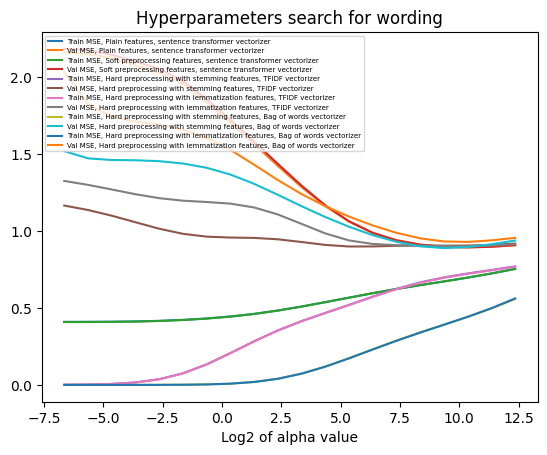

Best MSE for wording: 0.889933 for parameters set 4 and alpha=655.360


In [47]:
alphas = [0.01 * 2**i for i in range(0, 20)]


feature_variations = {
    'Plain features, sentence transformer vectorizer': {
        'features': ['text', 'text_word_cnt', 'text_length', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt'],
        'features_to_scale': ['text_word_cnt', 'text_length', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt'],
        'vectorizer': SentenceTransformerVectorizer(),
        'vectorizer_feature': "text",
        'prompt_processed_features': {
              'prompt_question': 'prompt_question',
              'prompt_title': 'prompt_title',
              'prompt_text': 'prompt_text'
          },
    },
    'Soft preprocessing features, sentence transformer vectorizer': {
        'features': ['text_soft_preprocessed', 'text_soft_preprocessed_word_cnt', 'text_soft_preprocessed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'features_to_scale': ['text_soft_preprocessed_word_cnt', 'text_soft_preprocessed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'vectorizer': SentenceTransformerVectorizer(),
        'vectorizer_feature': "text_soft_preprocessed",
        'prompt_processed_features': {
              'prompt_question': 'prompt_question_soft_preprocessed',
              'prompt_title': 'prompt_title_soft_preprocessed',
              'prompt_text': 'prompt_text_soft_preprocessed'
          },
    },
    'Hard preprocessing with stemming features, TFIDF vectorizer': {
        'features': ['text_hard_preprocessed_stemmed', 'text_hard_preprocessed_stemmed_word_cnt', 'text_hard_preprocessed_stemmed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'features_to_scale': ['text_hard_preprocessed_stemmed_word_cnt', 'text_hard_preprocessed_stemmed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'vectorizer': TfidfVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=1,
            max_features=30000
        ),
        'vectorizer_feature': "text_hard_preprocessed_stemmed",
        'prompt_processed_features': {
              'prompt_question': 'prompt_question_hard_preprocessed_stemmed',
              'prompt_title': 'prompt_title_hard_preprocessed_stemmed',
              'prompt_text': 'prompt_text_hard_preprocessed_stemmed'
          },
    },
    'Hard preprocessing with lemmatization features, TFIDF vectorizer': {
        'features': ['text_hard_preprocessed_lemmatized', 'text_hard_preprocessed_lemmatized_word_cnt', 'text_hard_preprocessed_lemmatized_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'features_to_scale': ['text_hard_preprocessed_lemmatized_word_cnt', 'text_hard_preprocessed_lemmatized_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'vectorizer': TfidfVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=1,
            max_features=30000
        ),
        'vectorizer_feature': "text_hard_preprocessed_lemmatized",
        'prompt_processed_features': {
              'prompt_question': 'prompt_question_hard_preprocessed_lemmatized',
              'prompt_title': 'prompt_title_hard_preprocessed_lemmatized',
              'prompt_text': 'prompt_text_hard_preprocessed_lemmatized'
          },
    },
    'Hard preprocessing with stemming features, Bag of words vectorizer': {
        'features': ['text_hard_preprocessed_stemmed', 'text_hard_preprocessed_stemmed_word_cnt', 'text_hard_preprocessed_stemmed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'features_to_scale': ['text_hard_preprocessed_stemmed_word_cnt', 'text_hard_preprocessed_stemmed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'vectorizer': CountVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=1,
            max_features=30000
        ),
        'vectorizer_feature': "text_hard_preprocessed_stemmed",
        'prompt_processed_features': {
              'prompt_question': 'prompt_question_hard_preprocessed_stemmed',
              'prompt_title': 'prompt_title_hard_preprocessed_stemmed',
              'prompt_text': 'prompt_text_hard_preprocessed_stemmed'
          },
    },
    'Hard preprocessing with lemmatization features, Bag of words vectorizer': {
        'features': ['text_hard_preprocessed_lemmatized', 'text_hard_preprocessed_lemmatized_word_cnt', 'text_hard_preprocessed_lemmatized_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'features_to_scale': ['text_hard_preprocessed_lemmatized_word_cnt', 'text_hard_preprocessed_lemmatized_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'vectorizer': CountVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=1,
            max_features=30000
        ),
        'vectorizer_feature': "text_hard_preprocessed_lemmatized",
        'prompt_processed_features': {
              'prompt_question': 'prompt_question_hard_preprocessed_lemmatized',
              'prompt_title': 'prompt_title_hard_preprocessed_lemmatized',
              'prompt_text': 'prompt_text_hard_preprocessed_lemmatized'
          },
    },
}

plt.title("Hyperparameters search for wording")

best_params_i = -1
best_params_alpha = -1
best_val_mse = np.inf

for i, feature_variation_name in enumerate(feature_variations):
    metrics_stats = {'train': [], 'val': []}
    
    print(feature_variation_name, "started")
    
    train_metrics, val_metrics = ridge_pipeline_evaluation(
        alphas,
        **feature_variations[feature_variation_name]
    )
    
    train_metrics = np.array(train_metrics).mean(axis=0)
    val_metrics = np.array(val_metrics).mean(axis=0)
    
    best_val_mse_here = np.min(val_metrics)
    if best_val_mse_here < best_val_mse:
        best_val_mse = best_val_mse_here
        best_params_alpha = alphas[np.argmin(val_metrics)]
        best_params_i = i

    plt.plot(np.log2(alphas), train_metrics, label=f"Train MSE, {feature_variation_name}")
    plt.plot(np.log2(alphas), val_metrics, label=f"Val MSE, {feature_variation_name}")
    
plt.xlabel('Log2 of alpha value')
plt.legend(prop={'size': 5}, loc="upper left")
plt.show()

print(f"Best MSE for wording: {best_val_mse:.6f} for parameters set {best_params_i} and alpha={best_params_alpha:.3f}")

#### Content model tuning

Plain features, sentence transformer vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.34s/it]


Soft preprocessing features, sentence transformer vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:56<00:00, 29.11s/it]


Hard preprocessing with stemming features, TFIDF vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:51<00:00, 27.88s/it]


Hard preprocessing with lemmatization features, TFIDF vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:47<00:00, 26.93s/it]


Hard preprocessing with stemming features, Bag of words vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:40<00:00, 40.24s/it]


Hard preprocessing with lemmatization features, Bag of words vectorizer started


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:37<00:00, 39.36s/it]


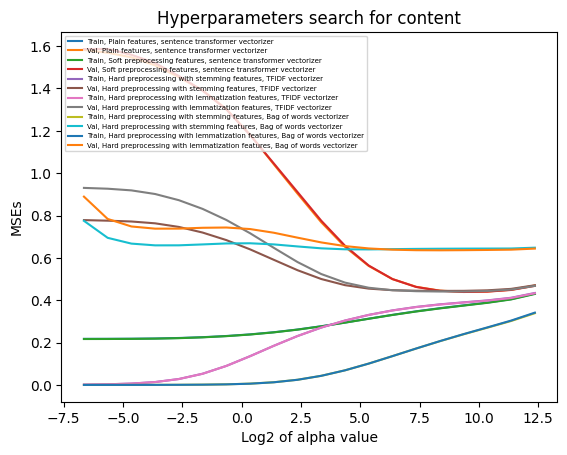

Best MSE for content: 0.439604 for parameters set 1 and alpha=655.360


In [46]:
plt.title("Hyperparameters search for content")

best_params_i = -1
best_params_alpha = -1
best_val_mse = np.inf

for i, feature_variation_name in enumerate(feature_variations):
    metrics_stats = {'train': [], 'val': []}
    
    print(feature_variation_name, "started")
    
    train_metrics, val_metrics = ridge_pipeline_evaluation(
        alphas,
        **feature_variations[feature_variation_name],
        target="content"
    )
    
    train_metrics = np.array(train_metrics).mean(axis=0)
    val_metrics = np.array(val_metrics).mean(axis=0)
    
    best_val_mse_here = np.min(val_metrics)
    if best_val_mse_here < best_val_mse:
        best_val_mse = best_val_mse_here
        best_params_alpha = alphas[np.argmin(val_metrics)]
        best_params_i = i

    plt.plot(np.log2(alphas), train_metrics, label=f"Train, {feature_variation_name}")
    plt.plot(np.log2(alphas), val_metrics, label=f"Val, {feature_variation_name}")

plt.ylabel("MSEs")
plt.xlabel('Log2 of alpha value')
plt.legend(prop={'size': 5}, loc="upper left")
plt.show()

print(f"Best MSE for content: {best_val_mse:.6f} for parameters set {best_params_i} and alpha={best_params_alpha:.3f}")

**Then the best hyperparameters are approximately:**
- Wording: 
    - Feature set:
    ```python
    {
        'features': ['text_hard_preprocessed_stemmed', 'text_hard_preprocessed_stemmed_word_cnt', 'text_hard_preprocessed_stemmed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'features_to_scale': ['text_hard_preprocessed_stemmed_word_cnt', 'text_hard_preprocessed_stemmed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'vectorizer': CountVectorizer(
            analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=1,
            max_features=30000
        ),
        'vectorizer_feature': "text_hard_preprocessed_stemmed",
        'prompt_processed_features': {
              'prompt_question': 'prompt_question_hard_preprocessed_stemmed',
              'prompt_title': 'prompt_title_hard_preprocessed_stemmed',
              'prompt_text': 'prompt_text_hard_preprocessed_stemmed'
          },
    }
    ```
    - Alpha: 655
- Content: 
    - Feature set:
    ```python
    {
        'features': ['text_soft_preprocessed', 'text_soft_preprocessed_word_cnt', 'text_soft_preprocessed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'features_to_scale': ['text_soft_preprocessed_word_cnt', 'text_soft_preprocessed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
        'vectorizer': SentenceTransformerVectorizer(),
        'vectorizer_feature': "text_soft_preprocessed",
        'prompt_processed_features': {
              'prompt_question': 'prompt_question_soft_preprocessed',
              'prompt_title': 'prompt_title_soft_preprocessed',
              'prompt_text': 'prompt_text_soft_preprocessed'
          },
    }
    ```
    - Alpha: 655

MCRMSE = 0.803

> **TODO**: Optimize hyperparameters search even more

### LightGBM

In [48]:
def lightgbm_pipeline_evaluation(params:dict,
                                 features: list,
                                  features_to_scale: list,
                                  target : str="wording", 
                                  vectorizer=TfidfVectorizer(
                                        analyzer='word',
                                        stop_words='english',
                                        ngram_range=(1, 3),
                                        lowercase=True,
                                        min_df=1,
                                        max_features=30000
                                    ),
                                  vectorizer_feature: str = "text",
                                  prompt_processed_features: dict = {
                                      'prompt_question': 'prompt_question',
                                      'prompt_title': 'prompt_title',
                                      'prompt_text': 'prompt_text'
                                  },
                                 verbose=False):
    
    train_metrics=[]
    val_metrics=[]
    
    if verbose:
        print(f"LightGBM starting")
    
    for i in tqdm(range(len(prompts_train_df))):
        val_prompt_id = prompts_train_df.loc[i, 'prompt_id']
        summaries_train, summaries_val = summaries_train_df[~(summaries_train_df['prompt_id'] == val_prompt_id)], summaries_train_df[summaries_train_df['prompt_id'] == val_prompt_id]

        X_train, y_train = summaries_train.loc[:, ['prompt_i', *features]], summaries_train.loc[:, target]
        X_val, y_val = summaries_val.loc[:, ['prompt_i', *features]], summaries_val.loc[:, target]
        
        vectorizer = vectorizer.fit(X_train[vectorizer_feature])
        train_summaries_vectors = vectorizer.transform(X_train[vectorizer_feature])
        val_summaries_vectors = vectorizer.transform(X_val[vectorizer_feature])
        
        prompts_texts_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_text']])
        prompts_titles_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_title']])
        prompts_questions_vectors = vectorizer.transform(prompts_train_df[prompt_processed_features['prompt_question']])
    
        scaler = RobustScaler().fit(X_train[features_to_scale])
        X_train[features_to_scale] = scaler.transform(X_train[features_to_scale])
        X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])

        y_scaler = RobustScaler().fit(y_train.to_numpy().reshape(-1, 1))
        y_train_scaled = y_scaler.transform(y_train.to_numpy().reshape(-1, 1))

        train_summaries_vectors_dense = train_summaries_vectors.todense()
        val_summaries_vectors_dense = val_summaries_vectors.todense()
        
        cosine_scores_train_prompts_texts = np.zeros((len(y_train), 1))
        cosine_scores_train_prompts_titles = np.zeros((len(y_train), 1))
        cosine_scores_train_prompts_questions = np.zeros((len(y_train), 1))
        
        for i, (summary_vector, prompt_text_vector, prompt_title_vector, prompt_question_vector) in enumerate(zip(train_summaries_vectors_dense, prompts_texts_vectors[X_train['prompt_i']].todense(), prompts_titles_vectors[X_train['prompt_i']].todense(), prompts_questions_vectors[X_train['prompt_i']].todense())):
            cosine_scores_train_prompts_texts[i, 0] = cosine_similarity(np.asarray(prompt_text_vector), np.asarray(summary_vector))
            cosine_scores_train_prompts_titles[i, 0] = cosine_similarity(np.asarray(prompt_title_vector), np.asarray(summary_vector))
            cosine_scores_train_prompts_questions[i, 0] = cosine_similarity(np.asarray(prompt_question_vector), np.asarray(summary_vector))

        cosine_scores_val_prompts_texts = np.zeros((len(y_val), 1))
        cosine_scores_val_prompts_titles = np.zeros((len(y_val), 1))
        cosine_scores_val_prompts_questions = np.zeros((len(y_val), 1))
        
        for i, (summary_vector, prompt_text_vector, prompt_title_vector, prompt_question_vector) in enumerate(zip(val_summaries_vectors_dense, prompts_texts_vectors[X_val['prompt_i']].todense(), prompts_titles_vectors[X_val['prompt_i']].todense(), prompts_questions_vectors[X_val['prompt_i']].todense())):
            cosine_scores_val_prompts_texts[i, 0] = cosine_similarity(np.asarray(prompt_text_vector), np.asarray(summary_vector))
            cosine_scores_val_prompts_titles[i, 0] = cosine_similarity(np.asarray(prompt_title_vector), np.asarray(summary_vector))
            cosine_scores_val_prompts_questions[i, 0] = cosine_similarity(np.asarray(prompt_question_vector), np.asarray(summary_vector))
        
        X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(cosine_scores_train_prompts_texts),
            sparse.coo_matrix(cosine_scores_train_prompts_titles),
            sparse.coo_matrix(cosine_scores_train_prompts_questions),
            sparse.coo_matrix(X_train[features_to_scale].to_numpy()),
        ))
        X_val = sparse.hstack((
            val_summaries_vectors,
            sparse.coo_matrix(cosine_scores_val_prompts_texts),
            sparse.coo_matrix(cosine_scores_val_prompts_titles),
            sparse.coo_matrix(cosine_scores_val_prompts_questions),
            sparse.coo_matrix(X_val[features_to_scale].to_numpy()),
        ))
        
        model = LGBMRegressor(**params, verbose = -1)
        model.fit(X_train, y_train_scaled.ravel())
        y_train_pred_scaled = model.predict(X_train)
        y_val_pred_scaled = model.predict(X_val)

        y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
        y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))

        train_mse = mean_squared_error(y_train_pred, y_train)
        val_mse = mean_squared_error(y_val_pred, y_val)
        if verbose:
            print(f"Train MSE for {target}: {train_mse_content:.3f}, Val MSE for content: {val_mse_content:.3f}")

        train_metrics.append(train_mse)
        val_metrics.append(val_mse)
                    
    return np.mean(train_metrics), np.mean(val_metrics)

In [49]:
def objective(trial, target="wording"):
    params = {
        "metric": "rmse",
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 1, 4),
        "n_estimators": trial.suggest_int("n_estimators", 10, 200), 
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq_1", 1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    feature_variation_name = trial.suggest_categorical(name='feature_variation_name', choices=feature_variations.keys())

    train_metric, val_metric = lightgbm_pipeline_evaluation(params, **feature_variations[feature_variation_name], target=target)
    
    return val_metric

#### Wording model tuning

In [50]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-10-09 22:26:29,354] A new study created in memory with name: no-name-272ce8e1-d618-4adf-be59-830c84e6f4e5
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:40<00:00, 25.06s/it]
[I 2023-10-09 22:28:09,602] Trial 0 finished with value: 0.9238068123909684 and parameters: {'lambda_l1': 1.0797269977448577e-06, 'lambda_l2': 1.595242275871438e-05, 'learning_rate': 0.13675758872122523, 'num_leaves': 173, 'max_depth': 4, 'n_estimators': 162, 'feature_fraction': 0.715864358514007, 'bagging_fraction': 0.6555557133219128, 'bagging_freq_1': 6, 'min_child_samples': 32, 'feature_variation_name': 'Soft preprocessing features, sentence transformer vectorizer'}. Best is trial 0 with value: 0.9238068123909684.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:39<00:00, 24.87s/it]
[I 2023-10-09 22:29:49,086] Trial 1 finished with value: 1.1749882835939032 and parameters: {'lambda_l1': 0.00234449441681

Number of finished trials: 3
Best trial: {'lambda_l1': 1.0797269977448577e-06, 'lambda_l2': 1.595242275871438e-05, 'learning_rate': 0.13675758872122523, 'num_leaves': 173, 'max_depth': 4, 'n_estimators': 162, 'feature_fraction': 0.715864358514007, 'bagging_fraction': 0.6555557133219128, 'bagging_freq_1': 6, 'min_child_samples': 32, 'feature_variation_name': 'Soft preprocessing features, sentence transformer vectorizer'}


#### Content model tuning

In [51]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, target="content"), n_trials=3)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-10-09 22:31:41,380] A new study created in memory with name: no-name-da342939-4f4d-4c9b-9e47-c3a8efa82e83
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:47<00:00, 26.96s/it]
[I 2023-10-09 22:33:29,562] Trial 0 finished with value: 0.4313537521451928 and parameters: {'lambda_l1': 0.014032708676056797, 'lambda_l2': 3.1327492062264755e-06, 'learning_rate': 0.02606444270072134, 'num_leaves': 157, 'max_depth': 3, 'n_estimators': 129, 'feature_fraction': 0.8989470956095813, 'bagging_fraction': 0.7257346864904977, 'bagging_freq_1': 11, 'min_child_samples': 45, 'feature_variation_name': 'Hard preprocessing with stemming features, TFIDF vectorizer'}. Best is trial 0 with value: 0.4313537521451928.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:46<00:00, 26.53s/it]
[I 2023-10-09 22:35:15,951] Trial 1 finished with value: 0.3508034127602536 and parameters: {'lambda_l1': 0.00164934440397

Number of finished trials: 3
Best trial: {'lambda_l1': 0.0016493444039769767, 'lambda_l2': 0.0004021305786744372, 'learning_rate': 0.05173524663090431, 'num_leaves': 223, 'max_depth': 2, 'n_estimators': 53, 'feature_fraction': 0.9276565805515549, 'bagging_fraction': 0.43763455560181214, 'bagging_freq_1': 9, 'min_child_samples': 77, 'feature_variation_name': 'Hard preprocessing with lemmatization features, TFIDF vectorizer'}


Best parameters found for LightGBMs:

    - 
- Wording:
    - LightGBM params:
```json
{
    'lambda_l1': 1.0797269977448577e-06, 'lambda_l2': 1.595242275871438e-05, 'learning_rate': 0.13675758872122523, 'num_leaves': 173, 'max_depth': 4, 'n_estimators': 162, 'feature_fraction': 0.715864358514007, 'bagging_fraction': 0.6555557133219128, 'bagging_freq_1': 6, 'min_child_samples': 32
}
```
    - Feature set:
```python
{
    'features': ['text_soft_preprocessed', 'text_soft_preprocessed_word_cnt', 'text_soft_preprocessed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
    'features_to_scale': ['text_soft_preprocessed_word_cnt', 'text_soft_preprocessed_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
    'vectorizer': SentenceTransformerVectorizer(),
    'vectorizer_feature': "text_soft_preprocessed",
    'prompt_processed_features': {
          'prompt_question': 'prompt_question_soft_preprocessed',
          'prompt_title': 'prompt_title_soft_preprocessed',
          'prompt_text': 'prompt_text_soft_preprocessed'
      },
}
```
- Content:
    - LightGBM params:
```json
{'lambda_l1': 0.0016493444039769767, 'lambda_l2': 0.0004021305786744372, 'learning_rate': 0.05173524663090431, 'num_leaves': 223, 'max_depth': 2, 'n_estimators': 53, 'feature_fraction': 0.9276565805515549, 'bagging_fraction': 0.43763455560181214, 'bagging_freq_1': 9, 'min_child_samples': 77}
```
    - Feature set:
```python
{
    'features': ['text_hard_preprocessed_lemmatized', 'text_hard_preprocessed_lemmatized_word_cnt', 'text_hard_preprocessed_lemmatized_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
    'features_to_scale': ['text_hard_preprocessed_lemmatized_word_cnt', 'text_hard_preprocessed_lemmatized_length', 'text_soft_preprocessed_stopword_cnt', 'text_soft_preprocessed_punct_cnt', 'text_soft_preprocessed_number_cnt'],
    'vectorizer': TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=1,
        max_features=30000
    ),
    'vectorizer_feature': "text_hard_preprocessed_lemmatized",
    'prompt_processed_features': {
          'prompt_question': 'prompt_question_hard_preprocessed_lemmatized',
          'prompt_title': 'prompt_title_hard_preprocessed_lemmatized',
          'prompt_text': 'prompt_text_hard_preprocessed_lemmatized'
      },
}
```

MCRMSE = `0.7766`